In [ ]:
import time
import random
import datetime
from collections import defaultdict

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline

from tensorflow.keras.models import Sequential, Model
from tensorflow.keras.layers import (
    Conv2D, BatchNormalization, Dropout, MaxPool2D,
    Flatten, Dense, Input, Concatenate, LeakyReLU, Add
)

# LOAD LIBRARIES
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from keras.utils.np_utils import to_categorical
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.callbacks import LearningRateScheduler

# How to check if Keras is using GPU?

from keras import backend as K

from keras.optimizers import SGD, Adam, Nadam

In [ ]:
train = pd.read_csv('./drive/My Drive/ml_data/number_cnn/train.csv')
test = pd.read_csv('./drive/My Drive/ml_data/number_cnn/test.csv')
submission = pd.read_csv('./drive/My Drive/ml_data/number_cnn/submission.csv')

In [ ]:
train

,id,digit,letter,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25,26,27,28,29,30,31,32,33,34,35,36,...,744,745,746,747,748,749,750,751,752,753,754,755,756,757,758,759,760,761,762,763,764,765,766,767,768,769,770,771,772,773,774,775,776,777,778,779,780,781,782,783
0,1,5,L,1,1,1,4,3,0,0,4,4,3,0,4,3,3,3,4,4,0,0,1,1,3,4,0,4,2,0,4,0,1,3,1,0,4,1,1,3,...,4,3,4,1,3,0,0,1,3,3,3,0,3,2,2,1,0,1,0,0,3,0,0,4,2,0,3,4,1,1,2,1,0,1,2,4,4,4,3,4
1,2,0,B,0,4,0,0,4,1,1,1,4,2,0,3,4,0,0,2,3,4,0,3,4,3,0,2,2,1,4,2,3,3,4,1,2,4,2,0,3,...,4,2,3,0,0,0,0,4,3,2,2,4,2,1,1,1,3,3,1,2,4,4,4,2,2,4,4,0,4,2,0,3,0,1,4,1,4,2,1,2
2,3,4,L,1,1,2,2,1,1,1,0,2,1,3,2,2,2,4,1,1,4,1,0,1,3,4,2,2,2,4,1,1,2,0,3,0,2,3,4,0,...,3,0,4,0,3,0,2,0,1,4,2,3,4,4,4,0,2,0,4,4,1,3,0,3,2,0,2,3,0,2,3,3,3,0,2,0,3,0,2,2
3,4,9,D,1,2,0,2,0,4,0,3,4,3,1,0,3,2,2,0,3,4,1,0,4,1,2,2,3,2,2,0,2,0,3,0,3,2,4,0,0,...,0,3,0,1,4,1,3,1,2,1,1,1,2,2,2,4,3,4,3,0,4,1,2,4,1,4,0,1,0,4,3,3,2,0,1,4,0,0,1,1
4,5,6,A,3,0,2,4,0,3,0,4,2,4,2,1,4,1,1,4,4,0,2,3,4,4,3,3,3,3,4,1,0,3,0,3,0,0,0,1,1,...,2,1,3,2,1,4,2,3,2,2,1,0,4,2,2,1,2,1,0,3,2,2,2,2,1,4,2,1,2,1,4,4,3,2,1,3,4,3,1,2
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2043,2044,6,V,2,4,3,4,2,4,4,1,2,1,3,3,4,4,3,4,1,0,4,4,4,1,1,1,2,3,4,1,2,3,3,2,3,1,3,4,0,...,2,4,1,1,1,1,2,3,1,2,0,2,4,1,0,3,4,4,0,1,3,3,3,3,2,0,3,3,3,2,0,2,2,0,0,1,3,1,4,0
2044,2045,1,L,3,2,2,1,1,4,0,1,4,2,0,3,3,2,2,1,2,3,2,2,4,1,0,4,1,0,2,0,3,0,2,3,3,3,4,0,4,...,0,1,1,1,1,3,0,4,2,0,4,3,1,4,0,1,0,0,3,3,0,0,1,3,3,1,2,0,3,2,2,3,4,2,1,2,3,4,1,1
2045,2046,9,A,4,0,4,0,2,4,4,4,3,4,0,1,3,4,1,0,2,2,0,0,3,3,2,0,4,3,2,3,4,3,1,1,4,4,4,1,1,...,3,2,4,3,2,1,1,0,4,0,4,4,1,3,3,1,3,4,1,0,2,4,1,2,4,4,4,3,4,2,2,3,1,1,3,4,2,2,0,0
2046,2047,0,Z,2,3,3,0,3,0,4,3,0,1,4,0,0,0,2,3,1,1,1,0,2,4,1,0,3,0,1,2,4,1,4,3,1,4,4,4,0,...,0,0,2,0,2,3,2,0,3,0,1,0,1,0,1,2,3,2,1,1,0,0,3,1,4,1,1,2,1,3,2,3,1,1,0,4,1,4,3,1


In [ ]:
train.shape

(2048, 787)

In [ ]:
train.query("letter == 'A'").iloc[28].iloc[:3]
# plt.imshow(train['1'])
# plt.show

id        774
digit       4
letter      A
Name: 773, dtype: object

In [ ]:
from scipy.signal import correlate2d

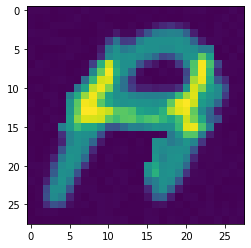

In [ ]:
# Image는 어떻게 생겼을까?
img = train.query("letter == 'A'")[[(str(i)) for i in range(784)]].iloc[28].values.reshape(28, 28)
plt.imshow(img)

In [ ]:
X_train = (train[[str(i) for i in range(784)]] / 255.).values.reshape(-1, 28, 28, 1)
y_train = to_categorical(train['digit'].values)

In [ ]:
X_train.shape

(2048, 28, 28, 1)

In [ ]:
# X_train

In [ ]:
# 아마 성능 향상의 가장 큰 요인, 데이터 증강
# CREATE MORE IMAGES VIA DATA AUGMENTATION
datagen = ImageDataGenerator(
        rotation_range=10,  
        zoom_range = 0.10,  
        width_shift_range=0.1, 
        height_shift_range=0.1)

In [ ]:
model = Sequential()
model.add(Conv2D(32, kernel_size = 3, activation='relu', input_shape = (28, 28, 1)))
model.add(Conv2D(32, kernel_size = 3, activation='relu'))
model.add(Conv2D(32, kernel_size = 5, strides=2, padding='same', activation='relu'))
model.add(Dropout(0.4))

model.add(Conv2D(64, kernel_size = 3, activation='relu'))
model.add(Conv2D(64, kernel_size = 3, activation='relu'))
model.add(Conv2D(64, kernel_size = 5, strides=2, padding='same', activation='relu'))
model.add(Dropout(0.4))

model.add(Conv2D(128, kernel_size = 4, activation='relu'))
model.add(Flatten())
model.add(Dropout(0.4))
model.add(Dense(10, activation='softmax'))

In [ ]:
# COMPILE WITH ADAM OPTIMIZER AND CROSS ENTROPY COST

model.compile(
    # optimizer=Adam(lr=0.001, beta_1=0.9, beta_2=0.999, epsilon=None, decay=0.0, amsgrad=False), 
    optimizer=Nadam(learning_rate=0.001, beta_1=0.9, beta_2=0.999, epsilon=1e-07),
    loss="categorical_crossentropy", 
    metrics=["accuracy"]
  )

In [ ]:
# DECREASE LEARNING RATE EACH EPOCH
annealer = LearningRateScheduler(lambda x: 1e-3 * 0.95 ** x)

In [ ]:
epochs = 100
# Train-Test를 9:1로 분리
X_train2, X_val2, y_train2, y_val2 = train_test_split(
    X_train, y_train, test_size = 0.1)

In [ ]:
datagenCheck = datagen.flow(X_train2, y_train2, batch_size=32)
datagenCheck

In [ ]:
history = model.fit_generator(
    datagen.flow(X_train2, y_train2, batch_size=32),
    epochs=epochs, 
    steps_per_epoch=X_train2.shape[0]//32,
    validation_data=(X_val2, y_val2), 
    callbacks=[annealer], 
    # verbose=0
)

print(
    f"CNN: Epochs={epochs:d}, " +
    f"Train accuracy={max(history.history['accuracy']):.5f}, " +
    f"Validation accuracy={max(history.history['val_accuracy']):.5f}"
)

Epoch 1/100
57/57 [==============================] - 2s 27ms/step - loss: 0.3006 - accuracy: 0.9023 - val_loss: 0.2891 - val_accuracy: 0.9024
Epoch 2/100
57/57 [==============================] - 1s 23ms/step - loss: 0.3190 - accuracy: 0.8973 - val_loss: 0.2145 - val_accuracy: 0.9317
Epoch 3/100
57/57 [==============================] - 1s 23ms/step - loss: 0.3309 - accuracy: 0.8874 - val_loss: 0.4471 - val_accuracy: 0.8634
Epoch 4/100
57/57 [==============================] - 1s 23ms/step - loss: 0.3040 - accuracy: 0.8956 - val_loss: 0.1606 - val_accuracy: 0.9463
Epoch 5/100
57/57 [==============================] - 1s 24ms/step - loss: 0.2819 - accuracy: 0.9008 - val_loss: 0.2020 - val_accuracy: 0.9317
Epoch 6/100
57/57 [==============================] - 1s 23ms/step - loss: 0.2807 - accuracy: 0.9078 - val_loss: 0.1979 - val_accuracy: 0.9366
Epoch 7/100
57/57 [==============================] - 1s 23ms/step - loss: 0.3030 - accuracy: 0.9023 - val_loss: 0.2429 - val_accuracy: 0.9366
Epoch 

In [ ]:
# Parameter 및 모델 구조 저장
model.save_weights(f'params.h5')
    
model_json = model.to_json()
with open(f"model.json", "w") as json_file : 
    json_file.write(model_json)

In [ ]:
# 예측 진행
X_test = (test[[str(i) for i in range(784)]] / 255.).values.reshape(-1, 28, 28, 1)
results = np.argmax(model.predict(X_test), axis=1)

In [ ]:
submission.digit = results
submission.to_csv('1234.csv', index=False) # 0.795575446%

## adam 그냥 제출했을 때 :: 0.8529411765
## adam epoch 200 :: 0.8431372549
## Adam(lr=0.001, beta_1=0.9, beta_2=0.999, epsilon=None, decay=0.0, amsgrad=False) 0.8578431373
## nadam 0.87254
